## Importing libraries

In [1]:
# Preprocessing Imports
# import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
# Model Imports
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

In [3]:
print(torch.cuda.is_available())       # Should be True

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))   # Name of the GPU (e.g., Tesla T4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

False


# System Identification

## Phase 1

### Load data

In [4]:
import pandas as pd

# Load data
df = pd.read_csv("../cessna_pitch_altitude.csv")
print(df)

       pitch_deg  altitude_ft
0        1.49593     40.52764
1        1.33864     40.59549
2        1.21016     40.63076
3        1.09080     40.65407
4        0.99866     40.66761
...          ...          ...
33613    3.68583     33.79496
33614    3.50730     33.75129
33615    3.32268     33.70770
33616    3.15426     33.66908
33617    2.98599     33.63131

[33618 rows x 2 columns]


### Exploratory Data Analysis (EDA)

In [5]:
# Check missing values, row, and colum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33618 entries, 0 to 33617
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pitch_deg    33618 non-null  float64
 1   altitude_ft  33618 non-null  float64
dtypes: float64(2)
memory usage: 525.4 KB


In [6]:
# Check basic stastics for each column
df.describe()

,pitch_deg,altitude_ft
count,33618.000000,33618.000000
mean,2.230197,433.542011
std,21.321148,243.101796
min,-54.464500,32.510630
25%,-12.232318,280.613587
50%,0.805050,424.547895
75%,16.586717,624.847413
max,61.598320,933.995730


<class 'numpy.ndarray'>


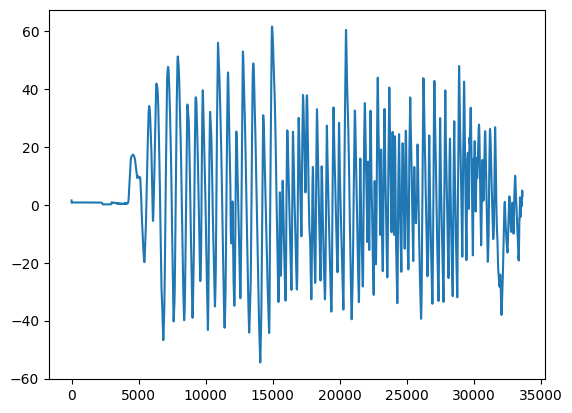

In [10]:
# Visualizing raw data

pitch = df['pitch_deg'].values
print(type(pitch))
plt.plot(pitch)

<class 'numpy.ndarray'>


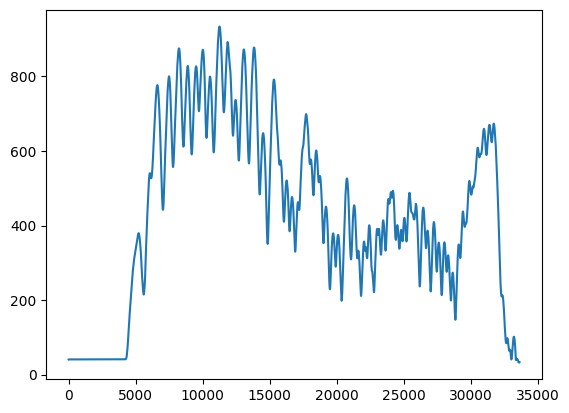

In [11]:
altitude = df['altitude_ft'].values
print(type(altitude))
plt.plot(altitude)

### Data Preprocessing

In [16]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["pitch_deg"],
    "x(t-1)" : df["pitch_deg"].shift(1),
    "x(t-2)" : df["pitch_deg"].shift(2),
    "x(t-3)" : df["pitch_deg"].shift(3),
    "t(t-1)" : df["altitude_ft"].shift(1),
    "t(t-2)" : df["altitude_ft"].shift(2),
    "t(t-3)" : df["altitude_ft"].shift(3),
    "t(t)"   : df["altitude_ft"]
})  

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

# Separate input and output
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "x(t-3)", "t(t-1)", "t(t-2)", "t(t-3)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size input and output
print(X.shape, T.shape)

      x(t)   x(t-1)   x(t-2)   x(t-3)    t(t-1)    t(t-2)    t(t-3)      t(t)
0  1.09080  1.21016  1.33864  1.49593  40.63076  40.59549  40.52764  40.65407
1  0.99866  1.09080  1.21016  1.33864  40.65407  40.63076  40.59549  40.66761
2  0.91885  0.99866  1.09080  1.21016  40.66761  40.65407  40.63076  40.67645
3  0.85195  0.91885  0.99866  1.09080  40.67645  40.66761  40.65407  40.68192
4  0.81336  0.85195  0.91885  0.99866  40.68192  40.67645  40.66761  40.68441
(33615, 8)
(33615, 7) (33615, 1)


In [18]:
def split_dataset_seq(X, T):
    train_size = int(0.7 * X.shape[0])
    val_size = int(0.15 * X.shape[0])

    X_train = X[:train_size]
    T_train = T[:train_size]

    X_val = X[train_size : train_size+val_size]
    T_val = T[train_size : train_size+val_size]

    X_test = X[train_size+val_size:]
    T_test = T[train_size+val_size:]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (23530, 7) (23530, 1)
Val  : (5042, 7) (5042, 1)
Test : (5043, 7) (5043, 1)


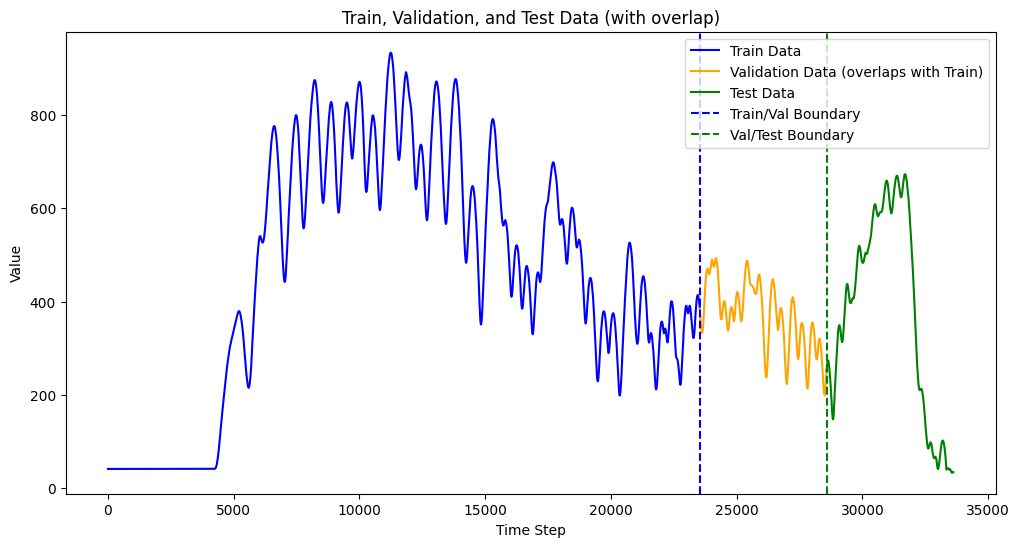

In [21]:
plt.figure(figsize=(12, 6))

train_size = int(0.7 * X.shape[0])
val_size = int(0.15 * X.shape[0])

# Define your index ranges explicitly
train_start, train_end = 0, train_size
val_start, val_end = train_size, train_size+val_size
test_start = train_size+val_size
test_end = test_start + len(T_test)

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), T_train, label='Train Data', color='blue')
plt.plot(range(val_start, val_end), T_val, label='Validation Data (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), T_test, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_end, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=val_end, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data (with overlap)")

plt.show()

In [22]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [10]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### MLP Model

In [11]:
input_dim = X_train.shape[1]    # 5
output_dim = T_train.shape[1]   # 1

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, output_dim)
    self.tanh = nn.Tanh()
  def forward(self, x):
    x = self.tanh(self.fc1(x))
    x = self.tanh(self.fc2(x))
    x = self.tanh(self.fc3(x))
    x = self.fc4(x)
    return x

model = MLP(input_dim, output_dim).to(device)

### Training and Validation

In [12]:
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def train(model, optimizer, loss_fn, X_train, T_train, X_val, T_val,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                pred = model(x)
                loss = loss_fn(pred, t)
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, 'first_checkpoint.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        # if patience_ctr >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

        if train_loss < tol:
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, 'first_checkpoint.pt')
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")
        
    return history

history = train(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.002019, val MSE 0.000483
Epoch 1: train MSE 0.000512, val MSE 0.000588
Epoch 2: train MSE 0.000317, val MSE 0.000526
Epoch 3: train MSE 0.000256, val MSE 0.000414
Epoch 4: train MSE 0.000208, val MSE 0.000194
Epoch 5: train MSE 0.000182, val MSE 0.000215
Epoch 6: train MSE 0.000177, val MSE 0.000089
Epoch 7: train MSE 0.000144, val MSE 0.000260
Epoch 8: train MSE 0.000132, val MSE 0.000123
Epoch 9: train MSE 0.000131, val MSE 0.000515
Epoch 10: train MSE 0.000112, val MSE 0.000038
Epoch 11: train MSE 0.000111, val MSE 0.000062
Epoch 12: train MSE 0.000106, val MSE 0.000111
Epoch 13: train MSE 0.000099, val MSE 0.000187
Epoch 14: train MSE 0.000104, val MSE 0.000049
Epoch 15: train MSE 0.000101, val MSE 0.000301
Epoch 16: train MSE 0.000091, val MSE 0.000054
Epoch 17: train MSE 0.000087, val MSE 0.000095
Epoch 18: train MSE 0.000089, val MSE 0.000277
Epoch 19: train MSE 0.000083, val MSE 0.000252
Epoch 20: train MSE 0.000082, val MSE 0.000046
Epoch 21: train MSE 0.0

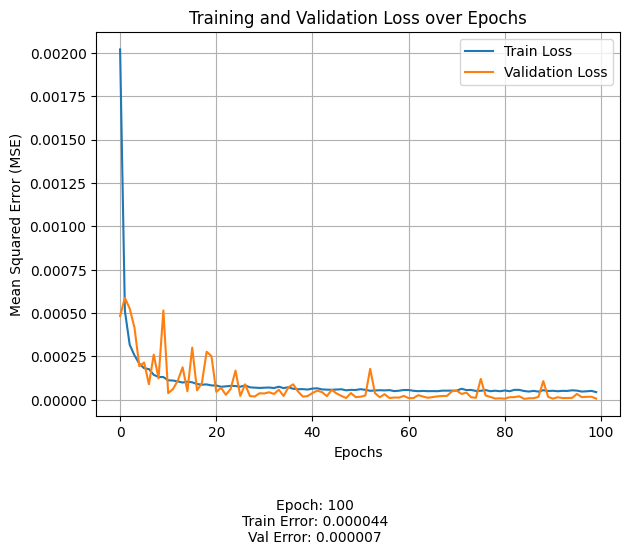

In [13]:
# Training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [26]:
checkpoint = torch.load('first_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
# Predictions
model.eval()
pred = []
with torch.no_grad():
  for i in range(len(Xtest)):
    x = Xtest[i]
    y_pred = model(x)
    pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (10000, 1)
type: <class 'numpy.ndarray'>, dim: (10000, 1)
[[ 4.3500934 ]
 [-2.7771819 ]
 [ 2.5422843 ]
 ...
 [ 0.66187733]
 [ 1.3821908 ]
 [-1.4401029 ]]
[[ 4.35796574]
 [-2.77562456]
 [ 2.54182954]
 ...
 [ 0.65102186]
 [ 1.37631971]
 [-1.43562832]]
mse test: 0.00020281788795632614


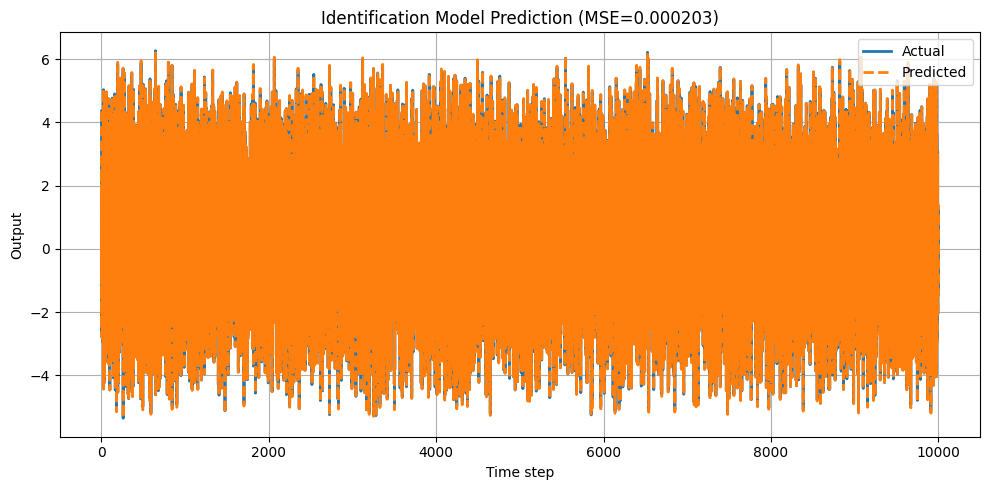

In [20]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Phase 2

### Data Preprocessing

In [21]:
# Generate dataset with lags
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]
})  

df_lagged = df_lagged.dropna().reset_index(drop=True)

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0 -3.828814 -2.795596  4.795879  0.317343
1  4.993798 -3.828814 -2.795596  3.305601
2 -7.173014  4.993798 -3.828814 -3.207550
3 -3.851533 -7.173014  4.993798  1.277608
4  1.746578 -3.851533 -7.173014  1.972003
(30000, 4)


In [22]:
# Separate input and output
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   
T = df_lagged[["t(t)"]].values   

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


In [23]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [24]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### Training and validation

In [27]:
# narx setup
y_lags = 2
# load the same model
model = MLP(input_dim, output_dim).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def trainNARX(model, optimizer, loss_fn, X_train, T_train, X_val, T_val, y_lags,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            x_aug = torch.cat((x, y_buffer), dim=0)
            optimizer.zero_grad()
            pred = model(x_aug)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            y_buffer = torch.cat([pred.detach(), y_buffer[1:]])
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                x_aug = torch.cat((x, y_buffer), dim=0)
                pred = model(x_aug)
                loss = loss_fn(pred, t)
                y_buffer = torch.cat([pred.detach(), y_buffer[1:]])
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # simpan di memory
            torch.save(model.state_dict(), 'best_model.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        # if patience_ctr >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

        if train_loss < tol:
            best_model_weights = model.state_dict()  # simpan di memory
            torch.save(model.state_dict(), 'best_model.pt')
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")
        
    return history, best_model_weights

history, best_model_weights = trainNARX(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, y_lags, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.000056, val MSE 0.000018
Epoch 1: train MSE 0.000058, val MSE 0.000022
Epoch 2: train MSE 0.000053, val MSE 0.000024
Epoch 3: train MSE 0.000054, val MSE 0.000034
Epoch 4: train MSE 0.000060, val MSE 0.000033
Epoch 5: train MSE 0.000058, val MSE 0.000031
Epoch 6: train MSE 0.000057, val MSE 0.000017
Epoch 7: train MSE 0.000058, val MSE 0.000013
Epoch 8: train MSE 0.000058, val MSE 0.000032
Epoch 9: train MSE 0.000056, val MSE 0.000017
Epoch 10: train MSE 0.000051, val MSE 0.000021
Epoch 11: train MSE 0.000049, val MSE 0.000029
Epoch 12: train MSE 0.000055, val MSE 0.000041
Epoch 13: train MSE 0.000053, val MSE 0.000014
Epoch 14: train MSE 0.000053, val MSE 0.001460
Epoch 15: train MSE 0.000046, val MSE 0.000043
Epoch 16: train MSE 0.000048, val MSE 0.000029
Epoch 17: train MSE 0.000055, val MSE 0.000020
Epoch 18: train MSE 0.000051, val MSE 0.000018
Epoch 19: train MSE 0.000053, val MSE 0.000016
Epoch 20: train MSE 0.000065, val MSE 0.000103
Epoch 21: train MSE 0.0

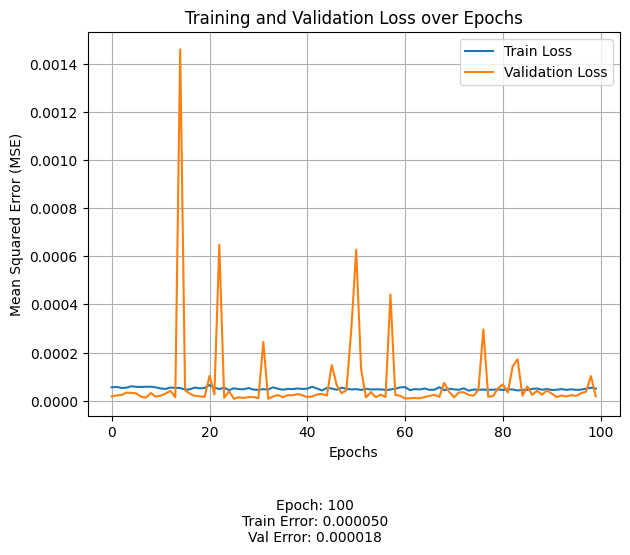

In [28]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]
last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [31]:
# Predictions
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
pred = []
y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
with torch.no_grad():
    for i in range(len(Xtest)): 
        x = Xtest[i]
        x_aug = torch.cat((x, y_buffer), dim=0)
        y_pred = model(x_aug) 
        y_buffer = torch.cat([y_pred.detach(), y_buffer[1:]])
        pred.append(y_pred.cpu().numpy()) 

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (10000, 1)
type: <class 'numpy.ndarray'>, dim: (10000, 1)
[[ 4.8741236]
 [-2.7958298]
 [ 2.5490026]
 ...
 [ 0.6568158]
 [ 1.3679368]
 [-1.4362413]]
[[ 4.35796574]
 [-2.77562456]
 [ 2.54182954]
 ...
 [ 0.65102186]
 [ 1.37631971]
 [-1.43562832]]
mse test: 0.0002566191417523051


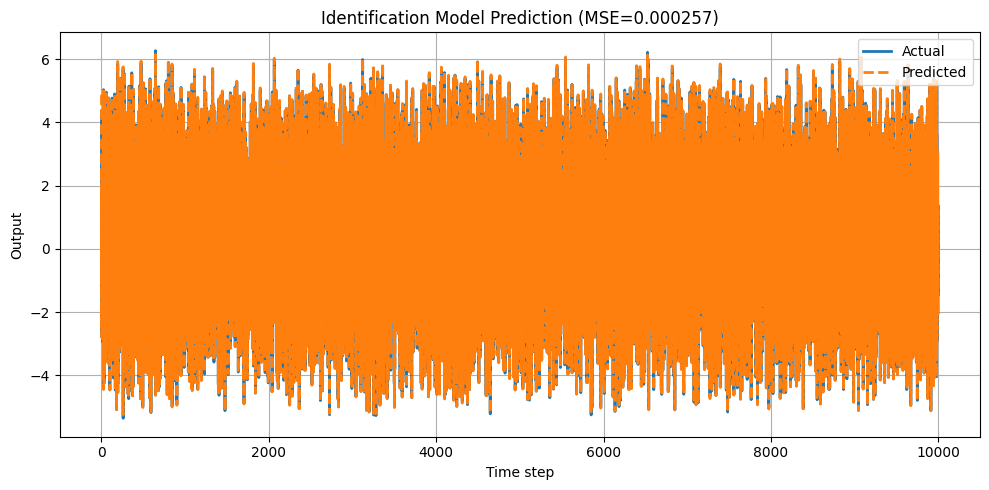

In [35]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()